In [4]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

In [6]:
%pip install "seaborn"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 6.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

In [15]:
# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Taxi-v3", render_mode="rgb_array")

129 {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}


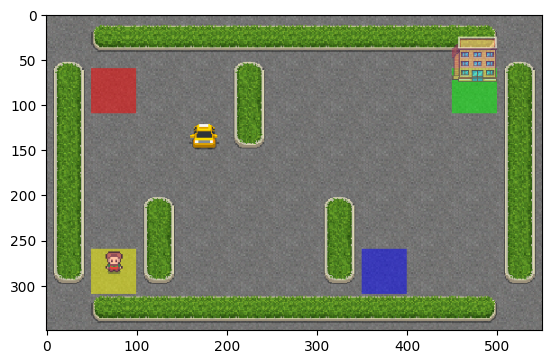

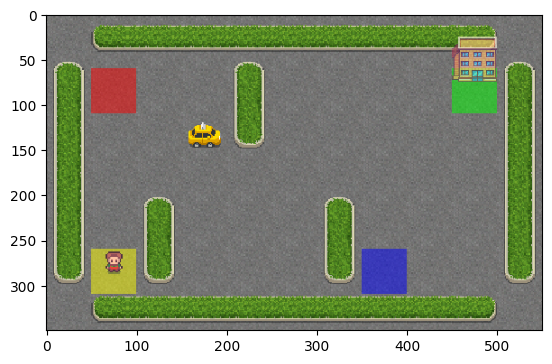

In [20]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

print(observation, info)

img = env.render()
plt.imshow(img)

# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}
plt.figure()
img = env.render()
plt.imshow(img)


In [22]:

class TaxiAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []


    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [23]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = TaxiAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [24]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [02:11<00:00, 760.15it/s]


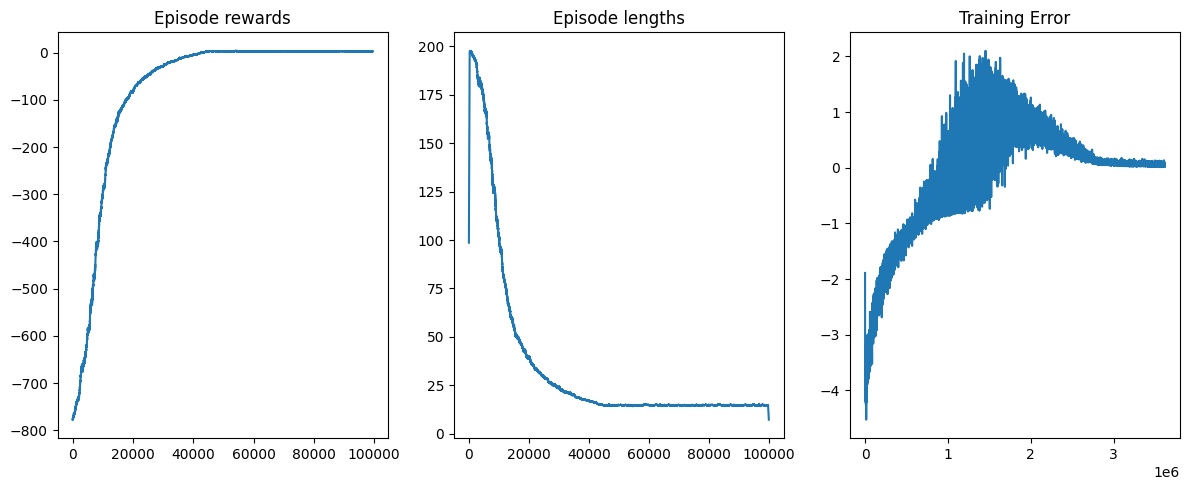

In [25]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()


In [34]:
import cv2

step_count = 0

# play one episode
obs, info = env.reset()
done = False
while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    # agent.update(obs, action, reward, terminated, next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

    img = env.render()
    step_count += 1

    print(step_count)
    cv2.imwrite(f"taxi_agent/{step_count}.png", img)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [65]:
import os
def create_video_from_images(folder):
    video_filename = 'created_video.avi'
    valid_images = [i for i in os.listdir(folder) if i.endswith((".jpg", ".jpeg", ".png"))]
    print(valid_images)
    first_image = cv2.imread(os.path.join(folder, valid_images[0]))
    h, w, _ = first_image.shape

    codec = cv2.VideoWriter_fourcc(*'avc1')
    vid_writer = cv2.VideoWriter("created_video.mp4", codec, 5.0, (w, h))

    for img in valid_images:
        loaded_img = cv2.imread(os.path.join(folder, img))
        # for _ in range(20):
        vid_writer.write(loaded_img)

    vid_writer.release()

# Create video from resized images
create_video_from_images("taxi_agent")



['11.png', '8.png', '19.png', '5.png', '3.png', '17.png', '18.png', '2.png', '10.png', '1.png', '12.png', '13.png', '14.png', '4.png', '9.png', '15.png', '7.png', '16.png', '6.png']


[ERROR:0@1315.070] global cap_ffmpeg_impl.hpp:3130 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@1315.070] global cap_ffmpeg_impl.hpp:3208 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


In [73]:
!ffmpeg -framerate 4 -i 'taxi_agent/%d.png' -c:v libx264 -preset slow -tune stillimage -crf 24 -vf format=yuv420p -t 10 -movflags +faststart -y output.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1+esm3 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1+esm3 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enabl

In [74]:
from IPython.display import Video

Video("output.mp4")